## Paquetes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

## Datasets

In [2]:
datasets_path = "/home/francisco/Documents/Practica/Time-Series-Library/datasets/"

In [3]:
coffee_df  = pd.read_csv(datasets_path+ 'Coffee_500Exog.csv')
coffee_results_df=  pd.read_csv(datasets_path+ 'Coffee_500Exog_results.csv')
sugar_df  = pd.read_csv(datasets_path+ 'Sugar_500Exog.csv')
sugar_results_df =  pd.read_csv(datasets_path+ 'Sugar_500Exog_results.csv')


## Funciones utiles

In [4]:
coffee_df_plot = sugar_df
coffee_df_plot['date'] = pd.to_datetime(coffee_df_plot['date'])
coffee_df_plot =coffee_df_plot.set_index('date')

<Axes: title={'center': 'Grafico azucar'}, xlabel='Fecha', ylabel='Value'>

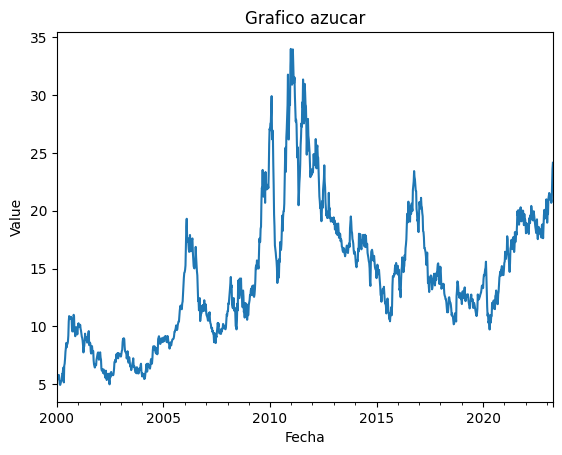

In [5]:
coffee_df_plot['value'].plot(title = 'Grafico azucar', xlabel = 'Fecha', ylabel = 'Value')

In [6]:
def load_squeeze(path):
    pred = np.load(path+'pred.npy')
    true = np.load(path+'true.npy')
    dates = np.load(path+'dates.npy')
    preds = np.squeeze(pred)
    trues = np.squeeze(true)
    dates = np.squeeze(dates)
    return dates,trues,preds

In [7]:
def load_squeeze_M(path):
    pred = np.load(path+'pred.npy')
    true = np.load(path+'true.npy')
    dates = np.load(path+'dates.npy')
    preds = np.squeeze(pred)
    trues = np.squeeze(true)
    dates = np.squeeze(dates)
    return dates,trues,preds

In [16]:
def create_df_stack(n,d,dates,trues,preds,df,xrnn=None):
    #Dataframe predicciones
    date_s = pd.Series(dates[0])
    date = pd.to_datetime(date_s, format='%Y%m%d')
    true_df = pd.DataFrame(trues[0])
    pred_df = pd.DataFrame(preds[0])
    date_df = date.to_frame()
    times_df = pd.concat([date_df,true_df,pred_df],axis=1)

    times_df.columns = ['date', 'true', 'Times' ]
    times_df.set_index('date',inplace=True)

        

    for i in range(1,n):
        date_s = pd.Series(dates[d*i])
        date = pd.to_datetime(date_s, format='%Y%m%d')
        
        pred_df = pd.DataFrame(preds[d*i])
        date_df = date.to_frame()
        times_df_n = pd.concat([date_df,pred_df],axis=1)

        times_df_n.columns = ['date', f'Times{d*i}' ]
        times_df_n.set_index('date',inplace=True)
        times_df = times_df.merge(times_df_n,on='date',how='outer')

        
    ## Dataframe xrn
    if xrnn is not None:
   
        xrnn = xrnn.iloc[:,[0,3]]
        xrnn.set_index('date',inplace=True)
        xrnn.index = pd.to_datetime(xrnn.index)
        xrnn.columns = ['Xrnn']
        ## Dataframe timesnet + xrnn
        total_df = times_df.join(xrnn,on='date')
        
    ## Dataframe contexto
    context = df[['date','value']]
    context.set_index('date',inplace=True)
    context.index = pd.to_datetime(context.index)
    ## Dataframe timesnet + xrnn + contexto
    if xrnn is not None:
        with_context =context.join(total_df, on='date')
        return with_context,total_df
    else:
        with_context = context.join(times_df, on='date')
        return with_context,times_df

In [9]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [10]:
def calc_metrics(y_actual, y_predicted):
    MSE = truncate(mean_squared_error(y_actual, y_predicted),2)
    RMSE = truncate(math.sqrt(MSE),2)
    MAE = truncate(mean_absolute_error(y_actual, y_predicted),2)
    MAPE = truncate(mean_absolute_percentage_error(y_actual, y_predicted),2)
    print("MSE: {} ---RMSE: {} ---MAE: {} ---MAPE: {}".format(MSE, RMSE, MAE, MAPE))
    return MSE, RMSE, MAE, MAPE

In [11]:
def graficar(virtual_present,path,df,result_df=None,N=0,D=0):
    resultados = '/home/francisco/Documents/Practica/Time-Series-Library/'
    path_resultados = resultados + path + '/'

    virtual_present= datetime.strptime(virtual_present, "%Y-%m-%d")
    test_start= virtual_present - relativedelta.relativedelta(weeks=52)
    
    date,true,pred = load_squeeze(path_resultados)
    
    result_wc,result_woc = create_df_stack(N,D,date,true,pred,df,result_df)

    w_context = result_wc[result_wc.index>test_start]
    
    wo_context = result_woc[result_woc.index>test_start]
    timesnet_metrics = calc_metrics(true[N],pred[N])
    xrnn_metrics = []
    if result_df is not None:
        xrnn_values =  result_df['units'].to_numpy()
        xrnn_metrics = calc_metrics(true[N],xrnn_values)
        
    
    return w_context,wo_context ,timesnet_metrics, xrnn_metrics

# Resultados Cafe

## Original

- Resultados obtenidos al utilizar el dataset de cafe para entrenamiento y el dataset de cafe para pruebas.

In [21]:
df_rolled = coffee_df.rolling(8,on='date',min_periods=1).sum()

/tmp/ipykernel_32154/653576082.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['id'], dtype='object')
  df_rolled = coffee_df.rolling(8,on='date',min_periods=1).sum()


In [13]:

coffee_df['date'] = pd.to_datetime(coffee_df['date'])
coffee_df.set_index('date', drop=True,inplace=True)
cols = list(coffee_df.columns)
cols.remove('id')
coffee_df = coffee_df[cols]


In [22]:
inte = coffee_df.cumsum()

In [29]:
path_present = 'results/Rolling_cafe_tn_PV:2021-12-13__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52'
vp_present = '2021-12-13'

In [30]:
wc , woc ,tn_metrics, xrnn_metrics= graficar(vp_present,path_present,df_rolled,N=0,D=0)

MSE: 257200.48 ---RMSE: 507.14 ---MAE: 497.12 ---MAPE: 0.27


In [31]:
mse,rms,mae,mape = tn_metrics


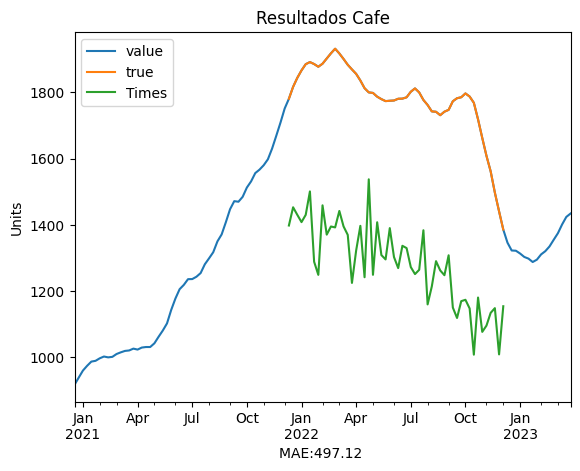

In [32]:
ax = wc.plot(title='Resultados Cafe',ylabel = 'Units' , xlabel = f'MAE:{mae} ')


<Axes: >

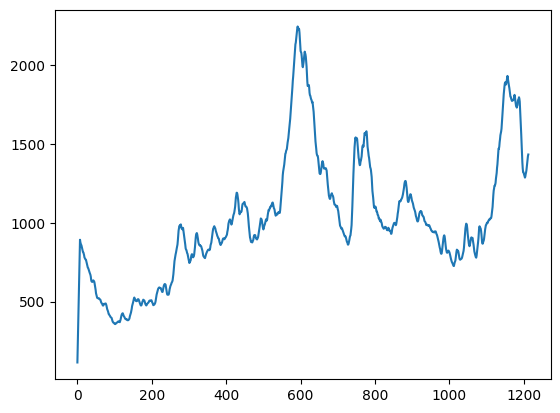

In [28]:
df_rolled['value'].plot()

## Presente virtual desplazado 52 semanas


In [ ]:
path_futuro = 'results/presente_futuro_PV:2022-01-01__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52'
vp_futuro = '2022-01-01'

In [ ]:
wc_futuro , woc_futuro,times_met,_ = graficar(vp_futuro,path_futuro,coffee_df,coffee_results_df,N=2,D=10)

FileNotFoundError: [Errno 2] No such file or directory: '/home/francisco/Documents/Practica/Time-Series-Library/results/presente_futuro_PV:2022-01-01__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52/pred.npy'

In [ ]:
_,_,mae,_ = times_met

<Axes: title={'center': 'Resultados cafe prediccion desplazada 52 semanas'}, xlabel='Fecha', ylabel='Units'>

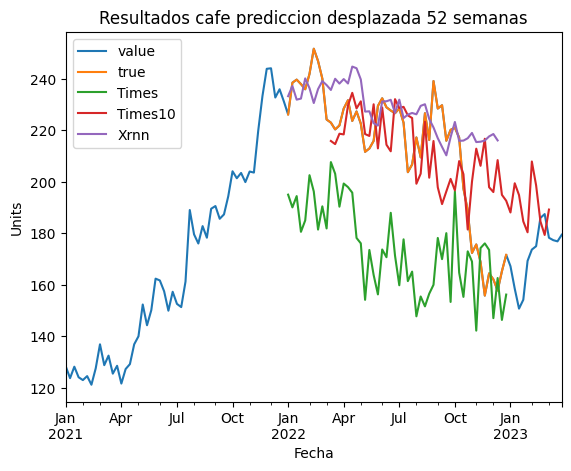

In [ ]:
wc_futuro.plot(title='Resultados cafe prediccion desplazada 52 semanas',ylabel = 'Units' , xlabel = 'Fecha')

In [ ]:
path_real = 'results/prueba_azucar_real_PV:2022-03-28__TimesNet_Sugar_500Exog.csv_sl52_ll26_pl52'
vp_real = '2022-03-28'

In [ ]:
wc_real , woc_freal,mae_t,mae_xr = graficar(vp_real,path_real,sugar_df,sugar_results_df,N=0,D=2)

MSE: 2.03 ---RMSE: 1.42 ---MAE: 1.1 ---MAPE: 0.05
MSE: 2.21 ---RMSE: 1.48 ---MAE: 1.26 ---MAPE: 0.06


In [ ]:
_,maet,_,_ = mae_t
_,maexr,_,_ = mae_xr

<Axes: title={'center': 'Cafe Train Azucar Test'}, xlabel='Times RMSE:1.42 XRNN RMSE:1.48', ylabel='Units'>

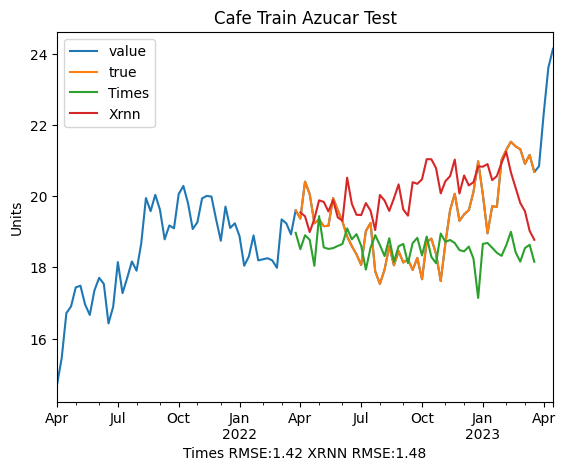

In [ ]:
wc_real.plot(title='Cafe Train Azucar Test',ylabel = 'Units' , xlabel = f'Times RMSE:{maet} XRNN RMSE:{maexr}')

# Azucar

## Original

In [ ]:
path_presente_az = 'results/presente_presente_PV:2021-01-01__TimesNet_Sugar_500Exog.csv_sl52_ll26_pl52'
vp_presente_az = '2021-01-01'

In [ ]:
wc_presente_az , woc_presente_az,m2,_ = graficar(vp_presente_az,path_presente_az,sugar_df,N=4,D=15)

MSE: 24.03 ---RMSE: 4.9 ---MAE: 4.56 ---MAPE: 0.24


In [ ]:
_,_,mae,_ = m2

<Axes: title={'center': 'Resultados Azucar'}, xlabel='date', ylabel='Units'>

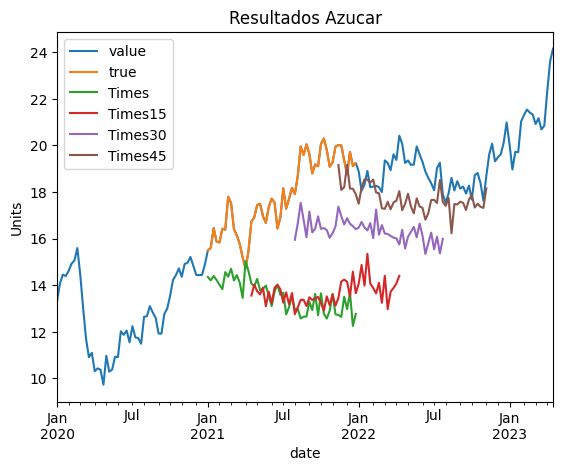

In [ ]:
wc_presente_az.plot(title='Resultados Azucar',ylabel = 'Units')

## Presente virtual desplazado 52 semanas

In [ ]:
path_futuro_az = 'results/presente_futuro_PV:2022-01-01__TimesNet_Sugar_500Exog.csv_sl52_ll26_pl52'
vp_futuro_az = '2022-01-01'

In [ ]:
wc_futuro_az , woc_futuro_az,m3,m10 = graficar(vp_futuro_az,path_futuro_az,sugar_df,sugar_results_df,N=2,D=10)

MSE: 1.65 ---RMSE: 1.28 ---MAE: 1.04 ---MAPE: 0.05
MSE: 2.68 ---RMSE: 1.63 ---MAE: 1.36 ---MAPE: 0.07


In [ ]:
_,maet,_,_ = m3
_,maexr,_,_ = m10

<Axes: title={'center': 'Resultados prediccion azucar desplazado 52 semanas'}, xlabel='Times RMSE:1.28 XRNN RMSE:1.63', ylabel='Units'>

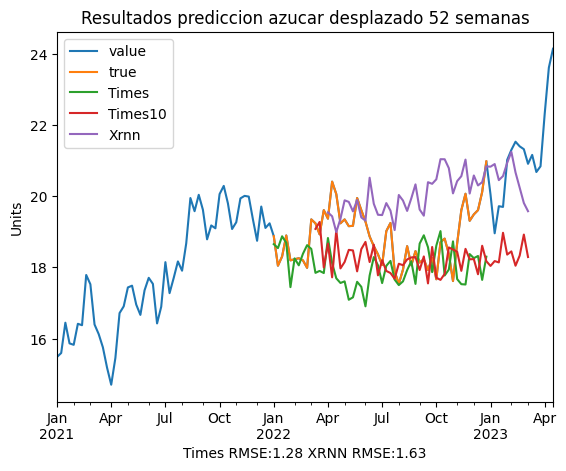

In [ ]:
wc_futuro_az.plot(title='Resultados prediccion azucar desplazado 52 semanas',ylabel = 'Units' , xlabel = f'Times RMSE:{maet} XRNN RMSE:{maexr}')

In [ ]:
path_real = 'results/prueba_azucar_real_PV:2022-03-28__TimesNet_Sugar_500Exog.csv_sl52_ll26_pl52'

In [ ]:
wc_real , woc_freal,_,_ = graficar(vp_real,path_real,sugar_df,sugar_results_df)

MSE: 2.03 ---RMSE: 1.42 ---MAE: 1.1 ---MAPE: 0.05
MSE: 2.21 ---RMSE: 1.48 ---MAE: 1.26 ---MAPE: 0.06


In [ ]:
otro = wc_real.join(wc_futuro_az['Times'],rsuffix='updated')

<Axes: xlabel='date'>

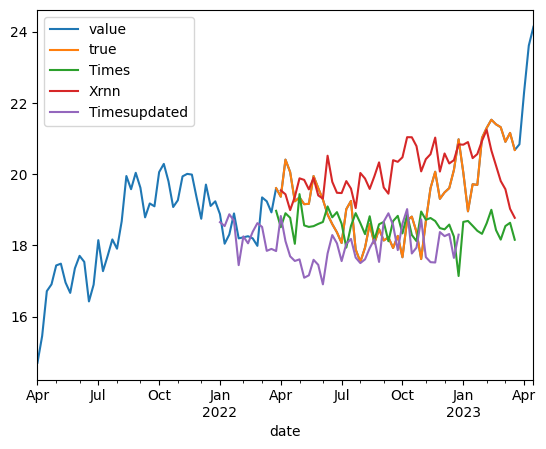

In [ ]:
otro.plot()

# Mezcla de datasets

## Azucar Train Cafe Test

In [ ]:
path_mix_cafe = 'results/presente_az_cafe_PV:2021-01-01__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52'
vp_mix_cafe = '2021-01-01'

In [ ]:
wc_mix_cafe , woc_mix_cafe,m5,_ = graficar(vp_mix_cafe,path_mix_cafe,coffee_df,N=4,D=15)

MSE: 5452.71 ---RMSE: 73.84 ---MAE: 61.47 ---MAPE: 0.31


In [ ]:
_,_,mae,_ = m5

<Axes: title={'center': 'Train:Azucar Test:Cafe'}, xlabel='date', ylabel='Units'>

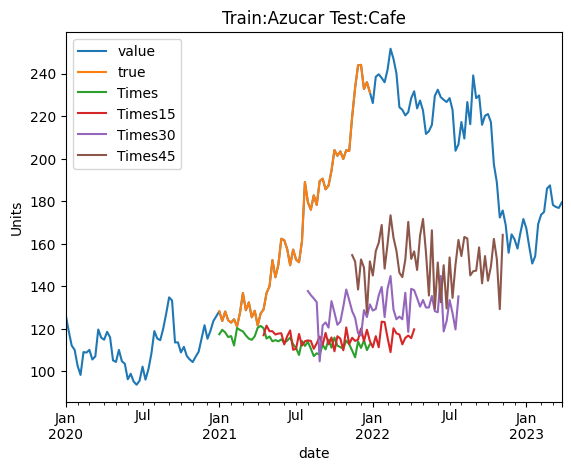

In [ ]:
wc_mix_cafe.plot(title='Train:Azucar Test:Cafe',ylabel = 'Units')

## Cafe Train Azucar Test

In [ ]:
path_mix_az = 'results/presente_ca_sugar_PV:2021-01-01__TimesNet_Sugar_500Exog.csv_sl52_ll26_pl52'
vp_mix_az = '2021-01-01'

In [ ]:
wc_mix_az , woc_mix_az,_,_ = graficar(vp_mix_az,path_mix_az,sugar_df,N=4,D=15)

MSE: 24.03 ---RMSE: 4.9 ---MAE: 4.56 ---MAPE: 0.24


<Axes: title={'center': 'Train:Cafe Test:Azucar'}, xlabel='Fecha', ylabel='Units'>

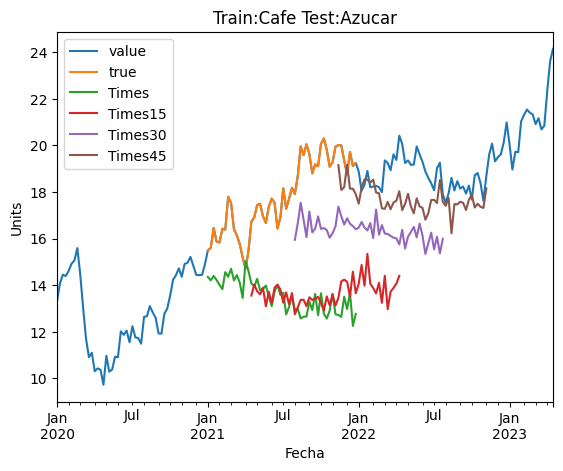

In [ ]:
wc_mix_az.plot(title='Train:Cafe Test:Azucar',ylabel = 'Units' , xlabel = 'Fecha')

# Por hacer

- Probar diferentes presentes virtuales (parametrizando) \ 


- Revisar las fechas y agregar parametro para guardar experimentes \ 
- Guardar metricas y generar funciones para cada experimento \  *
- Probar con mas datos  acordar a felipe\ 
- Revisar los hiperparametros(dmodel - factor) \
- Probar distintos modelos 
- Simplificar codigo y crear  funcion de prediccion solo con datos de prueba.
- Experimentos con bootstrapping

In [ ]:
last_path = 'results/prueba_pres_virt_cafe_azucar_PV:2021-12-13__TimesNet_Coffee_500Exog.csv_sl52_ll26_pl52'
last_pv = '2021-12-13'

In [ ]:
wc_real , woc_freal,m100,m100x = graficar(last_pv,last_path,coffee_df,coffee_results_df,N=0,D=5)

MSE: 3557.0 ---RMSE: 59.64 ---MAE: 55.54 ---MAPE: 0.24
MSE: 429.19 ---RMSE: 20.71 ---MAE: 14.36 ---MAPE: 0.07


In [ ]:
_,_,maet,_ = m100
_,_,maex,_ = m100x

<Axes: title={'center': 'AzucarTrain Cafe Test'}, xlabel='Times MAE:55.54 XRNN MAE:14.36 ', ylabel='Units'>

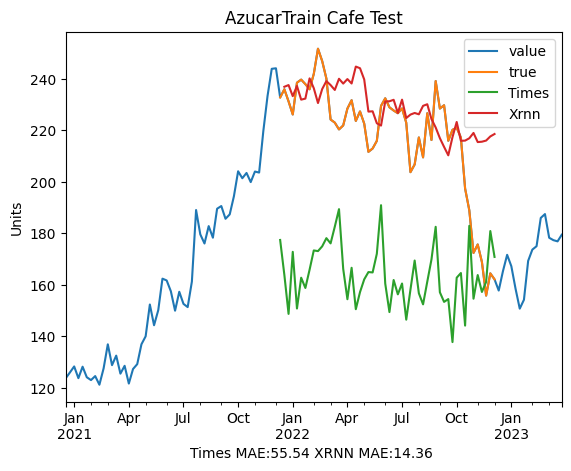

In [ ]:
wc_real.plot(title='AzucarTrain Cafe Test',ylabel = 'Units' , xlabel = f'Times MAE:{maet} XRNN MAE:{maex} ')